In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

import matplotlib.pyplot as plt
import seaborn as sns
from brukeropusreader import read_file
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Categorical, Integer
import warnings
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras.initializers import RandomNormal, lecun_uniform
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adamax, Nadam
from tensorflow.keras.initializers import he_normal, glorot_uniform, lecun_uniform, RandomNormal
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from itertools import cycle
from itertools import product
from tensorflow.keras.layers import Dense, AlphaDropout

warnings.filterwarnings('ignore')  # Ignore all warnings

2024-06-11 12:34:22.177059: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 12:34:22.953362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 12:34:22.953410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 12:34:22.953442: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 12:34:22.972378: I tensorflow/core/platform/cpu_feature_g

In [2]:

# Chemins vers vos dossiers
folder_path_oe = 'OE tissue'
folder_path_re = 'RE tissue'
folder_path_trachea = 'Trachea tissue'

In [3]:
class GradientLogger(Callback):
    def __init__(self, model, validation_data):
        super(GradientLogger, self).__init__()
        self.model = model
        self.validation_data = validation_data
        self.grads = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        with tf.GradientTape() as tape:
            y_pred = self.model(x_val, training=True)
            loss = self.model.compiled_loss(y_val, y_pred)
        grads = tape.gradient(loss, self.model.trainable_weights)
        avg_grads = [tf.reduce_mean(tf.abs(grad)) for grad in grads]
        self.grads.append(avg_grads)
        print(f'End of epoch {epoch + 1}, average gradients: {avg_grads}')
        
        # Optionally, plot the gradients
        self.plot_gradients(epoch)

    def plot_gradients(self, epoch):
        plt.figure(figsize=(12, 8))
        for i, grad in enumerate(self.grads[-1]):
            plt.plot(i, grad, 'bo')
        plt.title(f'Gradient magnitudes at epoch {epoch + 1}')
        plt.xlabel('Layer')
        plt.ylabel('Average Gradient Magnitude')
        plt.show()

In [4]:
# Fonction pour lister les fichiers dans un dossier
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# Lister les fichiers dans chaque dossier
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_trachea = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

print("\nOE Folder:")
print(f"Number of files: {len(files_oe)}")
print("Files:", files_oe)

print("\nTrachea Folder:")
print(f"Number of files: {len(files_trachea)}")
print("Files:", files_trachea)

RE Folder:
Number of files: 159
Files: ['19022024 RE 5.0000', '20240318 RE B2.0000', '20240318 RE B3.0003', '20240415 C2 RE.0003', '20240311 RE 3.0003', '20240311 RE 2.0003', '20240304 RE 4.0004', '20240408 C2 RE.0004', '20240318 RE B5.0000', '19022024 RE 1.0000', '19022024 RE 4.0000', '20240304 RE 3.0004', '20240311 RE 1.0005', '20240311 RE 5.0001', '19022024 RE 2.0000', '20240318 RE B3.0004', '20240311 RE 1.0008', '20240408 C4 RE.0003', '20240415 C4 RE.0003', '20240415 C1 RE.0000', '19022024 RE 4.0001', '20240318 RE B2.0001', '19022024 RE 3.0004', '20240304 RE 2.0004', '19022024 RE 1.0003', '20240304 RE 1.0003', '20240311 RE 3.0002', '19022024 RE 2.0004', '20240311 RE 5.0003', '20240311 RE 4.0004', '19022024 RE 4.0003', '20240415 C3 RE.0001', '20240408 C3 RE.0002', '20240304 RE 3.0000', '20240408 C5 RE.0001', '20240415 C3 RE.0000', '20240311 RE 1.0006', '20240415 C1 RE.0002', '20240408 C2 RE.0000', '20240311 RE 1.0001', '20240318 RE B4.0004', '20240311 RE 1.0007', '20240318 RE B1.000

In [5]:
# Définir l'ensemble commun de nombres d'onde
start_wavenumber = 5000  # Le nombre d'onde de départ
end_wavenumber = 400  # Le nombre d'onde de fin
resolution = 1  # La résolution en cm⁻¹

# Générer l'ensemble commun de nombres d'onde
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Vérifiez la première et dernière valeurs ainsi que la taille de l'ensemble pour s'assurer qu'il correspond à vos attentes
print("Premier nombre d'onde :", common_wavenumbers[0])
print("Dernier nombre d'onde :", common_wavenumbers[-1])
print("Nombre total de points :", len(common_wavenumbers))

Premier nombre d'onde : 5000
Dernier nombre d'onde : 400
Nombre total de points : 4601


In [6]:
def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    # Supposons que les nombres d'onde sont stockés dans une clé 'WN' dans les données retournées
    # Extraire le nombre de points, le nombre d'onde de début et de fin
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
# Générer la liste des nombres d'onde
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    
    return wavenumbers

In [7]:
def get_spectral_data(file_path):
    """
    Extracts spectral data (e.g., absorbance values) from a file.

    Parameters:
    - file_path: The path to the Bruker file.

    Returns:
    - A numpy array containing the spectral data.
    """
    opus_data = read_file(file_path)
    # Assuming the spectral data is stored in the 'AB' key
    spectral_data = opus_data['AB']
    return spectral_data

# You may need to adjust the `read_file` function to return the entire opus_data dictionary.


In [8]:
def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    """
    Interpolates the spectral data from a file to a common set of wavenumbers.
    
    Parameters:
    - file_path: The path to the file.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of the interpolated spectral data.
    """
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

In [9]:
def z_score_normalize(data):
    """
    Normalizes a data array using Z-score normalization.
    
    Parameters:
    - data: A numpy array of spectral data.
    
    Returns:
    - The Z-score normalized spectral data.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

In [10]:
def process_directory(folder_path, common_wavenumbers):
    """
    Processes all files in a directory, interpolating and normalizing their spectral data.
    
    Parameters:
    - folder_path: The path to the directory.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of all the normalized spectral data from the directory.
    """
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

In [11]:
# Process directories
data_oe = process_directory('OE tissue', common_wavenumbers)
data_re = process_directory('RE tissue', common_wavenumbers)
data_trachea = process_directory('Trachea tissue', common_wavenumbers)

In [12]:
print(data_trachea)

[[-0.43538375 -0.64356274 -0.77298818 ...  0.39308826  0.36916473
   0.49461767]
 [-0.75578922 -0.87746623 -0.88927893 ...  0.31542172  0.25797865
   0.29027234]
 [-0.54263948 -0.56064104 -0.55290233 ...  0.23331368  0.1631412
  -0.31985712]
 ...
 [-0.92601706 -1.05006522 -0.97390053 ...  0.3779646   0.67449012
   0.31427256]
 [-0.55153291 -0.57190038 -0.56460868 ...  0.20039     0.30499168
  -0.36811427]
 [-0.68651559 -0.82865621 -0.95439433 ...  0.37128463  0.35695602
   0.58641616]]


In [13]:
# Vérifier si la liste des fichiers n'est pas vide
if files_trachea:
    first_file_trachea = files_trachea[0]
    print("Le premier fichier dans le dossier 'Trachea tissue' est:", first_file_trachea)
else:
    print("Aucun fichier trouvé dans le dossier.")

Le premier fichier dans le dossier 'Trachea tissue' est: 20240311 TE 5.0004


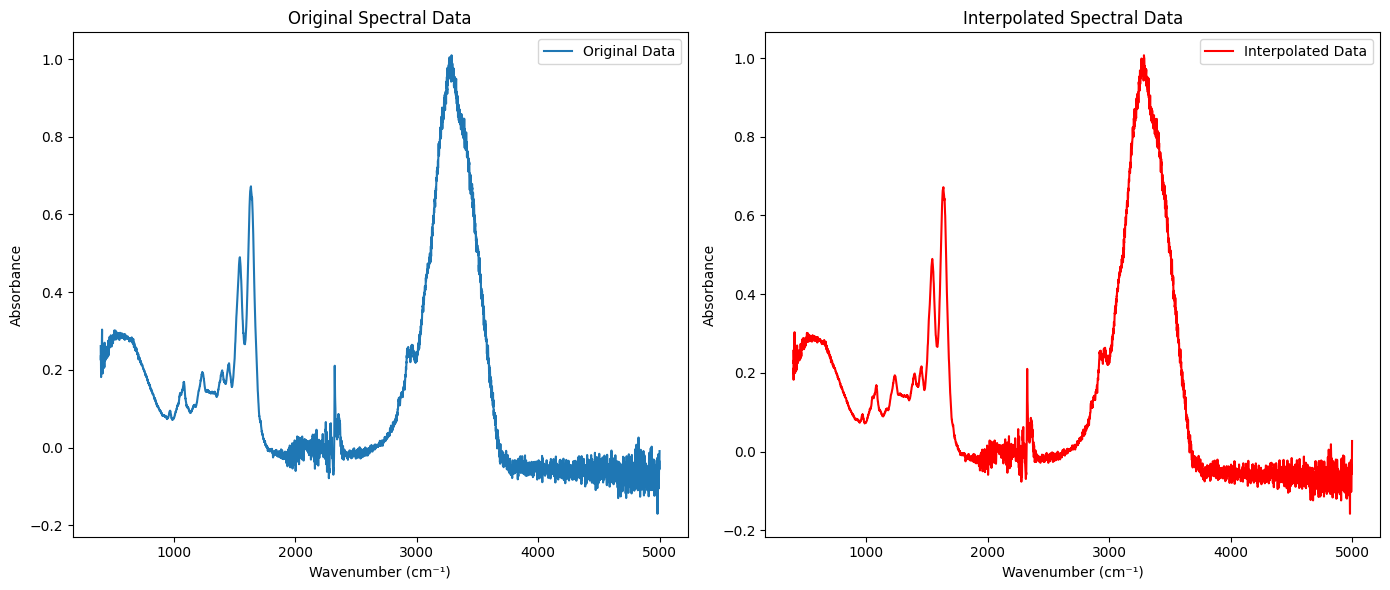

In [14]:
def plot_original_vs_interpolated(file_path, common_wavenumbers):
    # Obtenir les données spectrales et les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    
    # Interpolation des données aux nombres d'onde communs
    interpolated_data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)

    # Tracer les données originales
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1ère subplot
    plt.plot(original_wavenumbers, original_data, label='Original Data')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Original Spectral Data')
    plt.legend()

    # Tracer les données interpolées
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème subplot
    plt.plot(common_wavenumbers, interpolated_data, label='Interpolated Data', color='red')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Interpolated Spectral Data')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation sur un fichier spécifique
# Chemin complet du premier fichier
first_file_path = os.path.join(folder_path_trachea, first_file_trachea)

# Utilisation du fichier pour tracer les données originales et interpolées
plot_original_vs_interpolated(first_file_path, common_wavenumbers)

In [15]:
def print_wavenumber_range(file_path, common_wavenumbers):
    # Extraire les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    
    # Afficher la plage des nombres d'onde originaux
    print("Plage des nombres d'onde originaux:")
    print(" - Min:", np.min(original_wavenumbers))
    print(" - Max:", np.max(original_wavenumbers))
    
    # Afficher la plage des nombres d'onde interpolés
    print("Plage des nombres d'onde interpolés:")
    print(" - Min:", np.min(common_wavenumbers))
    print(" - Max:", np.max(common_wavenumbers))

# Utilisation du premier fichier du dossier "Trachea tissue"
folder_path_trachea = 'Trachea tissue'
files_trachea = list_files(folder_path_trachea)

if files_trachea:
    first_file_trachea = files_trachea[0]
    first_file_path = os.path.join(folder_path_trachea, first_file_trachea)
    print_wavenumber_range(first_file_path, common_wavenumbers)
else:
    print("Aucun fichier trouvé dans le dossier.")

Plage des nombres d'onde originaux:
 - Min: 399.9009272456169
 - Max: 4999.296694397926
Plage des nombres d'onde interpolés:
 - Min: 400
 - Max: 5000


In [16]:
# Fonction pour filtrer les nombres d'onde dans deux plages spécifiques et les concaténer
def filter_and_concatenate_wavenumbers(data, wavenumbers, ranges):
    filtered_data_list = []
    filtered_wavenumbers_list = []
    
    for min_w, max_w in ranges:
        indices = np.where((wavenumbers >= min_w) & (wavenumbers <= max_w))[0]
        if len(indices) == 0:
            print(f"Aucun indice trouvé pour la plage {min_w}-{max_w}")
            continue
        print(f"Indices trouvés pour la plage {min_w}-{max_w}: {indices}")
        filtered_data_list.append(data[:, indices])
        filtered_wavenumbers_list.append(wavenumbers[indices])
    
    if not filtered_data_list:
        raise ValueError("Aucun indice valide trouvé dans les plages spécifiées.")
    
    concatenated_data = np.concatenate(filtered_data_list, axis=1)
    concatenated_wavenumbers = np.concatenate(filtered_wavenumbers_list)
    
    return concatenated_data, concatenated_wavenumbers

# Définir les plages de filtres
ranges = [(900, 1800)]
#ranges = [(2800, 3000), (900, 1800)]
#ranges = [(400, 5000)]

In [17]:
# Vérification des limites
print(f"common_wavenumbers: min={common_wavenumbers.min()}, max={common_wavenumbers.max()}")

# Filtrer et concaténer les données de chaque tissu
try:
    data_oe, common_wavenumbers = filter_and_concatenate_wavenumbers(data_oe, common_wavenumbers, ranges)
    data_re, common_wavenumbers = filter_and_concatenate_wavenumbers(data_re, common_wavenumbers, ranges)
    data_trachea, common_wavenumbers = filter_and_concatenate_wavenumbers(data_trachea, common_wavenumbers, ranges)

    # Vérifiez la première et dernière valeurs ainsi que la taille de l'ensemble filtré pour s'assurer qu'il correspond à vos attentes
    print("Premier nombre d'onde filtré :", common_wavenumbers[0])
    print("Dernier nombre d'onde filtré :", common_wavenumbers[-1])
    print("Nombre total de points filtrés :", len(common_wavenumbers))
except IndexError as e:
    print(f"Erreur d'indexation: {e}")
except ValueError as e:
    print(f"Erreur de valeur: {e}")

common_wavenumbers: min=400, max=5000
Indices trouvés pour la plage 900-1800: [3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213
 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227
 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241
 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255
 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269
 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3280 3281 3282 3283
 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295 3296 3297
 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311
 3312 3313 3314 3315 3316 3317 3318 3319 3320 3321 3322 3323 3324 3325
 3326 3327 3328 3329 3330 3331 3332 3333 3334 3335 3336 3337 3338 3339
 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353
 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367
 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381

In [18]:
# Assuming data_oe, data_re, data_trachea have already been calculated as shown in previous messages
# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

In [19]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


In [20]:
# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [21]:
# Assuming X and y are your dataset features and labels respectively
# First, split the data into a temporary training dataset and final test set
#X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, split the temporary training dataset into actual training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# At this point:
# X_train and y_train are for training the model.
# X_val and y_val are for validating and tuning the model.
# X_test and y_test are for the final evaluation of the model.

#print("Training set size: ", X_train.shape[0])
#print("Validation set size: ", X_val.shape[0])
#print("Test set size: ", X_test.shape[0])

In [22]:
#learning_rates = [0.01, 0.001]
#num_layers_list = [4, 8]
#neurons_per_layer_list = [100, 300]
#dropout_rates = [0.1, 0.3, 0.5]
#initializers = ['he_normal', 'glorot_uniform', 'lecun_uniform', 'random_normal']
#optimizers = ['adam', 'sgd', 'adagrad']


In [23]:
#Best Parameters: {'learning_rate': 0.01, 'num_layers': 8, 'neurons_per_layer': 300, 'dropout_rate': 0.1, 'initializer': 'random_normal', 'optimizer': 'sgd'}


In [24]:
# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 333
Validation set size: 111
Test set size: 111


In [25]:
# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [26]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y_temp)
class_weights = dict(enumerate(class_weights))

In [29]:
# Define the function to create the model
def create_model(learning_rate, num_layers, neurons_per_layer, dropout_rate, initializer, optimizer, l2_lambda, l1_lambda, clipnorm=clipnorm):
    initializers = {
        'he_normal': he_normal(),
        'glorot_uniform': glorot_uniform(),
        'lecun_uniform': lecun_uniform(),
        'random_normal': RandomNormal()
    }
    
    optimizers = {
        'adam': Adam(learning_rate=learning_rate, clipnorm=clipnorm),
        'sgd': SGD(learning_rate=learning_rate, clipnorm=clipnorm),
        'rmsprop': RMSprop(learning_rate=learning_rate, clipnorm=clipnorm),
        'adagrad': Adagrad(learning_rate=learning_rate, clipnorm=clipnorm),
        'adamax': Adamax(learning_rate=learning_rate, clipnorm=clipnorm),
        'nadam': Nadam(learning_rate=learning_rate, clipnorm=clipnorm)
    }
    
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation='relu', kernel_initializer=initializers[initializer], 
                    kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu', kernel_initializer=initializers[initializer],
                        kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for OE, RE, Trachea
    
    model.compile(optimizer=optimizers[optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [30]:
# Define model hyperparameters
learning_rate = 0.001
num_layers = 5
neurons_per_layer = 70
dropout_rate = 0.46
initializer = 'glorot_uniform'  # Xavier initialization
optimizer = 'adam'
batch_size = 128
epochs = 600
l2_lambda = 0.1
l1_lambda = 0.01  # L1 regularization factor
clipnorm = 0.00001

Epoch 1/600
3/3 [==============================] - 3s 117ms/step - loss: 88.3427 - accuracy: 0.3183 - val_loss: 87.3833 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/600
3/3 [==============================] - 0s 18ms/step - loss: 88.0472 - accuracy: 0.3514 - val_loss: 87.2333 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/600
3/3 [==============================] - 0s 18ms/step - loss: 88.2298 - accuracy: 0.3153 - val_loss: 87.0583 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/600
3/3 [==============================] - 0s 18ms/step - loss: 87.8616 - accuracy: 0.3003 - val_loss: 86.8630 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/600
3/3 [==============================] - 0s 18ms/step - loss: 87.4931 - accuracy: 0.3904 - val_loss: 86.6449 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/600
3/3 [==============================] - 0s 18ms/step - loss: 87.3310 - accuracy: 0.3033 - val_loss: 86.4108 - val_accuracy: 0.2883 - lr: 0.0010
Epoch 7/600
3/3 [==============================] - 0s 18ms/step - los

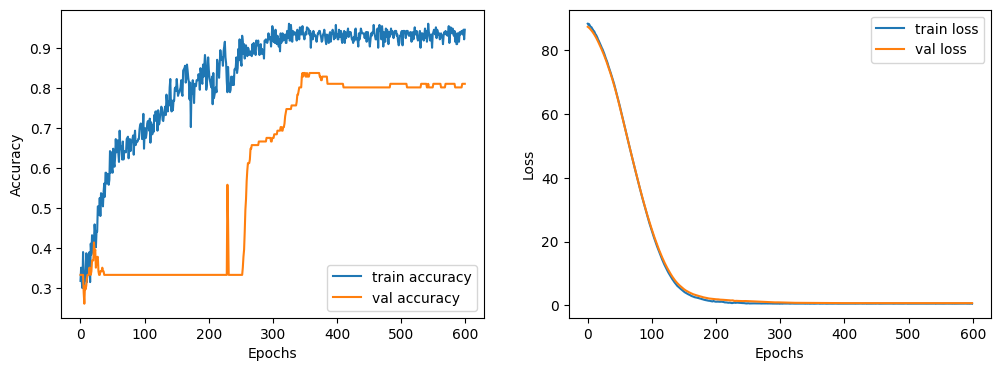

4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.69      0.80      0.74        30
           2       0.81      0.69      0.75        36

    accuracy                           0.85       111
   macro avg       0.83      0.83      0.83       111
weighted avg       0.85      0.85      0.85       111

[[45  0  0]
 [ 0 24  6]
 [ 0 11 25]]


In [39]:
# Define model hyperparameters
learning_rate = 0.001
num_layers = 5
neurons_per_layer = 70
dropout_rate = 0.46
initializer = 'glorot_uniform'  # Xavier initialization
optimizer = 'adam'
batch_size = 128
epochs = 600
l2_lambda = 0.1
l1_lambda = 0.01  # L1 regularization factor
clipnorm = 0.00001

# Create model with L1 and L2 regularization and gradient clipping
model = create_model(learning_rate, num_layers, neurons_per_layer, dropout_rate, initializer, optimizer, l2_lambda, l1_lambda, clipnorm)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

# Train model
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size, verbose=1, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))

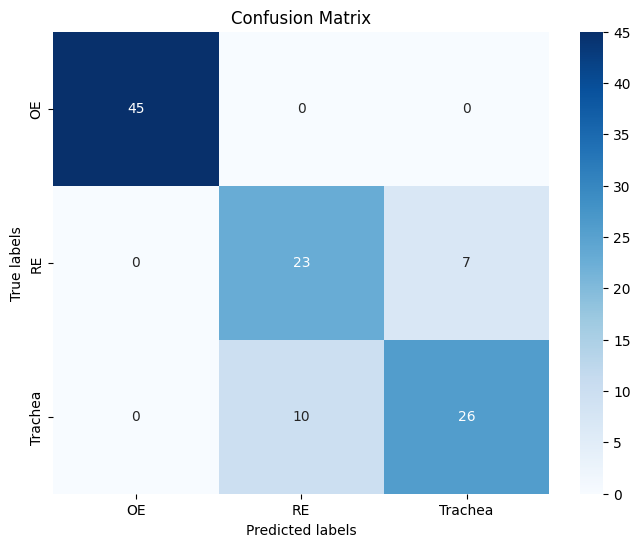

In [34]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Create the heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['OE', 'RE', 'Trachea'], 
            yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

4/4 [==============================] - 0s 2ms/step


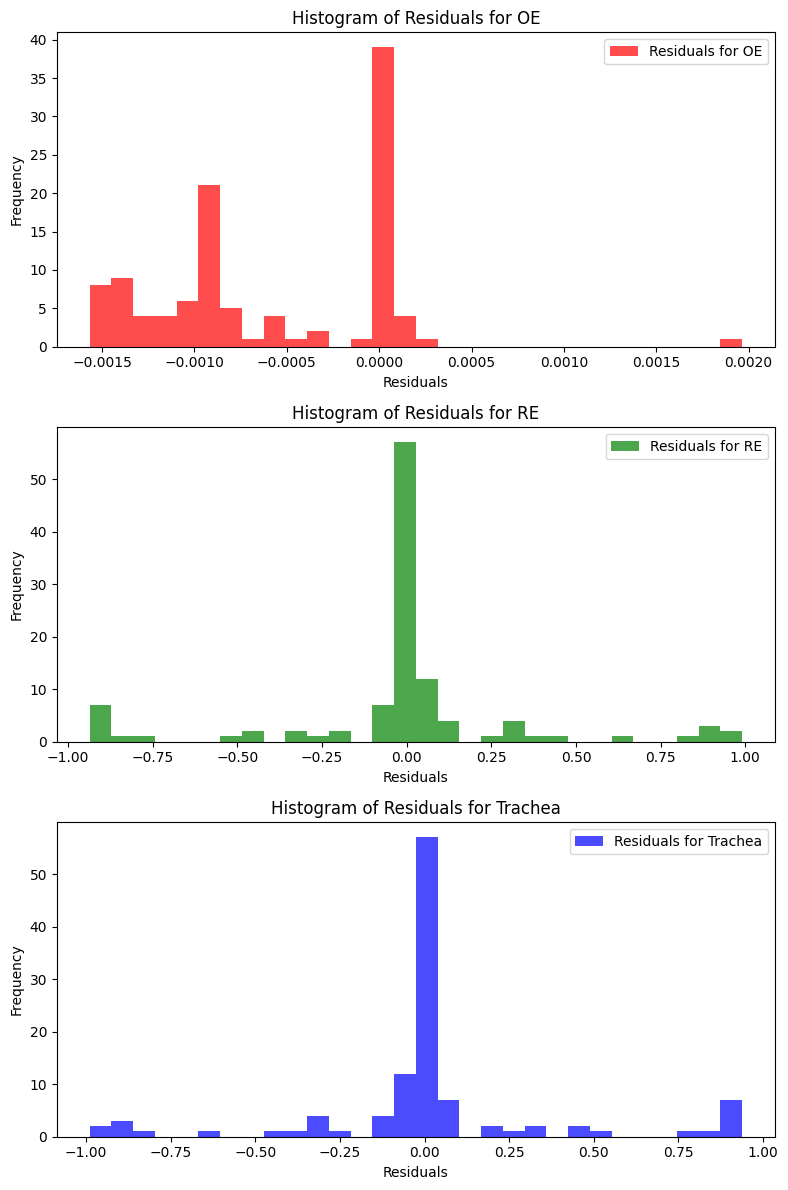

In [35]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict probabilities for each class
y_probs = model.predict(X_test)

# Binarize the test labels
class_names = ['OE', 'RE', 'Trachea']
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Calculate "residuals" for each class
residuals = [y_test_binarized[:, i] - y_probs[:, i] for i in range(n_classes)]

# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

colors = ['red', 'green', 'blue']
labels = ['OE', 'RE', 'Trachea']

# Plot histograms of residuals for each class
for i, ax in enumerate(axes):
    ax.hist(residuals[i], bins=30, color=colors[i], alpha=0.7, label=f'Residuals for {labels[i]}')
    ax.set_title(f'Histogram of Residuals for {labels[i]}')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


In [66]:
from sklearn.model_selection import KFold
import numpy as np

# Parameters
epochs = 600
batch_size = 128

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store the scores
cv_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Convert labels to categorical
    y_train_fold_cat = to_categorical(y_train_fold)
    y_val_fold_cat = to_categorical(y_val_fold)
    
    # Create a new instance of the model
    model2 = create_model(learning_rate, num_layers, neurons_per_layer, dropout_rate, initializer, optimizer, l2_lambda, l1_lambda, clipnorm)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)
    
    # Train the model
    history = model2.fit(X_train_fold, y_train_fold_cat, epochs=epochs, validation_data=(X_val_fold, y_val_fold_cat), batch_size=batch_size, verbose=1, callbacks=[early_stopping, lr_scheduler])
    
    # Evaluate the model on the validation set
    val_loss, val_accuracy = model2.evaluate(X_val_fold, y_val_fold_cat, verbose=0)
    cv_scores.append(val_accuracy)

# Calculate the average and standard deviation of the scores, rounded to 2 decimal places
average_score = np.mean(cv_scores)
std_deviation = np.std(cv_scores)

# Print the results, rounded to 2 decimal places
print("Cross-validation scores:", cv_scores)
print("Average score:", f"{average_score:.2f}")
print("Standard deviation of scores:", f"{std_deviation:.2f}")



Epoch 1/600
4/4 [==============================] - 4s 78ms/step - loss: 86.9834 - accuracy: 0.3468 - val_loss: 86.2944 - val_accuracy: 0.3153 - lr: 0.0010
Epoch 2/600
4/4 [==============================] - 0s 12ms/step - loss: 86.8658 - accuracy: 0.3333 - val_loss: 86.0831 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 3/600
4/4 [==============================] - 0s 12ms/step - loss: 86.6009 - accuracy: 0.3401 - val_loss: 85.8203 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 4/600
4/4 [==============================] - 0s 12ms/step - loss: 86.1656 - accuracy: 0.3626 - val_loss: 85.5065 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 5/600
4/4 [==============================] - 0s 12ms/step - loss: 85.8494 - accuracy: 0.3896 - val_loss: 85.1491 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 6/600
4/4 [==============================] - 0s 12ms/step - loss: 85.4622 - accuracy: 0.3671 - val_loss: 84.7680 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 7/600
4/4 [==============================] - 0s 12ms/step - loss

4/4 [==============================] - 0s 2ms/step


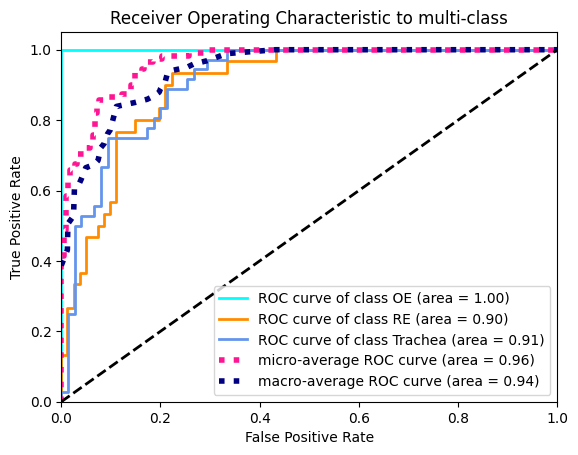

In [37]:
class_names = ['OE', 'RE', 'Trachea']
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, (color, class_name) in enumerate(zip(colors, class_names)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model.save('modele_2 FFN.h5')
